# Build jsons for timed experiment

## Json format:

```
{

"level1":[
            {url:"url1", time: 100, label:"fake"},  # time in msec
            {url:"url2", time: 3000, label:"real"},
            
            ...
         ],
"level2":[
            {url:"url1", time: 100, label:"fake"},
            {url:"url2", time: 3000, label:"fake"},
            ...
            
         ],
"level3":[
            {url:"url1", time: 100, label:"real"},
            {url:"url2", time: 3000, label:"fake"},
            ...
            
         ]

.
.
.

}
```




## Structure of the jsons

- 50% real, 50% fake (balanced prevalence), but also 15% fake (low prevalence)
- Control the fakeness of deepfakes (work with elements that don't have obvious artifacts)
- Create versions with and without caricatures
- Same participant across different times
- Practice trials
- In each level, different times, but randomize order
- Balance the number of videos shown, number of times within a level, times shown per video
- Make sure we show caricatures and fakes an equal amount of times
- Mix both caricatures and deepfakes in one level

For practice trials:
- Start with longest time, decrease shown times and random at the end 
- Send the distribution of jsons

# Remaining tasks

- [ ] Ensure the number of times across levels is balanced
- [ ] Ensure the number of real/fakes across levels is balanced
- [ ] Measure the number of times we need to show each json to get around ~10 responses per video and per time

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random
import requests
import glob

In [2]:
# Load list of real deepfake URLs
def load_urls_from_jsons(json_folder):
    df_urls = set()
    for f in os.listdir(json_folder):
        if not f.endswith('.json'): continue
        j = json.load(open(os.path.join(json_folder,f)))
        for k in j.keys():
            for u in j[k]:
                df_urls.add(u)

    print("\nLoaded %d deepfake urls" % len(df_urls))

    return df_urls

deepfake_urls = load_urls_from_jsons('exp2_jsons')


Loaded 1015 deepfake urls


In [3]:
def build_label_dict(metadata_path='../metadata.json'):
    '''Checks metadata.json (in DeepfakeDetection main folder) to see if input f has a fake label. Returns true if it does.'''

    # Load metadata
    metadata = json.load(open(metadata_path))

    label_dict={}

    # Build label dict
    for part in metadata.values():
        for video, d in part.items():
            label_dict[video[:-4]] = d['label']
    
    return label_dict

def load_caricature_urls(base_url, label_dict):
    '''Loads all caricatures from a given base url. Returns a list of urls.'''

    urls = set()
    r = requests.get(base_url)
    # Loop over elements in caricature folder from visiongpu url
    for f in r.text.split('\n'):

        # Get the substring from f in between href=" and "
        f = f[f.find('href="')+6:f.find('"', f.find('href="')+6)]

        # Skip non mp4 files
        if not f.endswith('.mp4'): continue
        

        # if file corresponds to gradcam caricature with amp10:
        if 'cari' in f and 'gradcam_amp10' in f:
            # Check in metadata if f is a deepfake
            if label_dict[f.split('_')[0]]=='FAKE':
                urls.add(os.path.join(base_url,f))

    return urls
      
def load_real_urls(base_url, label_dict):
    '''Loads all real videos from a given base url. Returns a list of urls.'''

    urls = set()
    r = requests.get(base_url)
    # Loop over elements in caricature folder from visiongpu url
    for f in r.text.split('\n'):

        # Get the substring from f in between href=" and "
        f = f[f.find('href="')+6:f.find('"', f.find('href="')+6)]

        # Skip non mp4 files
        if not f.endswith('.mp4'): continue
        
        if label_dict.get(f[:-4], None)=='REAL':
                urls.add(os.path.join(base_url,f))

    return urls

label_dict = build_label_dict()
cari_urls = load_caricature_urls("http://visiongpu23.csail.mit.edu/scratch/datasets/DeepfakeDetection/caricatures/", label_dict)
real_urls = load_real_urls("http://visiongpu23.csail.mit.edu/scratch/datasets/DeepfakeDetection/caricatures/", label_dict)
print("%d cari_urls loaded" %len(cari_urls))
print("%d real urls loaded" %len(real_urls))

199 cari_urls loaded
200 real urls loaded


In [4]:
def get_fake_urls_from_cari_urls(cari_urls):
    '''Extracts the 10-character filename of each cari url and builds new url with it'''

    fake_urls = set()
    for url in cari_urls:
        fake_urls.add(url.split('_')[0]+'.mp4')

    return fake_urls

fake_urls = get_fake_urls_from_cari_urls(cari_urls)
print("%d fake urls loaded" % len(fake_urls))

199 fake urls loaded


In [5]:
def create_jsons_for_timed_experiment(real_urls, fake_urls, cari_urls, pres_times, number_of_levels_per_json, number_of_elems_per_level, reps):
    '''Creates a set of jsons assigning all real and fake urls to different jsons, 
    according to the number_of_elems_per_level and the number of levels per json.
    This function assumes that all fake and cari urls have to appear in al least one json, and that they have to be shown 
    at least 'reps' times for each presentation time.
    The jsons will have:
    - Level 0: practice trial
    - In each level, each deepfake is shown for different times, but the order of those times is randomized
    - In one json, there can be no repeated fakes or caris
    - Balance the number of videos shown, number of times within a level, times shown per video
    - Make sure we show caricatures and fakes an equal amount of times
    - Mix both caricatures and deepfakes in one level, but have some levels without caricatures at all'''

    jsons = []

    # Each Cari and Fake can be shown only once per json. Different pres_times and reps need to be shown in different jsons.

    number_of_jsons_to_make = int(np.ceil((len(fake_urls)+len(cari_urls))/(number_of_elements_per_level*number_of_levels_per_json/2))*len(pres_times)*reps)
    print("For the given parameters, %d jsons will be generated to ensure that all fakes and caris are shown at least %d times for each pres_time" % (number_of_jsons_to_make, reps))



    # Generate list of pres_times for fakes and caris, ensuring each fake/cari can be shown at least once per each time

    pres_times_fake = {}
    pres_times_cari = {}
    for u in fake_urls:
        pres_times_fake[u] = random.sample(pres_times, len(pres_times))*reps

    for u in cari_urls:
        pres_times_cari[u] = random.sample(pres_times, len(pres_times))*reps

    # Create copy of urls
    fake_urls_cpy = fake_urls.copy()
    cari_urls_cpy = cari_urls.copy()
    real_urls_cpy = real_urls.copy()
    



    for i in range(number_of_jsons_to_make):

        # Create empty json
        j = {}

        # Every json must have a balanced number of real/fake, around 25% caricatures and 25% deepfakes, 
        # a balanced number of pres_times, and show each video only once. Across all jsons, we should have a balanced number of times per video 


        # Create list of REAL labels
        real_labels = ["REAL"]*int(np.ceil(number_of_elems_per_level*number_of_levels_per_json/2))

        # Create list of FAKE labels
        fake_labels = ["FAKE"]*int(np.ceil(number_of_elems_per_level*number_of_levels_per_json/4))

        # Create list of CARI labels
        cari_labels = ["CARI"]*int(np.ceil(number_of_elems_per_level*number_of_levels_per_json/4))

        # Concatenate the lists
        labels = real_labels + fake_labels + cari_labels
        np.random.shuffle(labels)
        

        # pres_times_fake = pres_times*len(cari_urls)*reps
        # pres_times_cari = pres_times*int(number_of_elems_per_level*number_of_levels_per_json/len(pres_times)/2 +1)
        # np.random.shuffle(pres_times_list)

        # Ensure pres_times_list and labels are both larger than number_of_elems_per_level*number_of_levels_per_json
        assert(len(labels) >= number_of_elems_per_level*number_of_levels_per_json)

        no_pres_times=False
    
        # Create levels
        for l in range(number_of_levels_per_json):

            if no_pres_times: break
            j["level%d"%l] = []
            
            # Add videos to level by popping for shuffled list of labels and pres_times
            for t in range(number_of_elems_per_level):

                # Assign urls to jsons
                lab = labels.pop()
                if lab=="REAL":
                    if len(real_urls_cpy)==0:
                        real_urls_cpy = real_urls.copy()
                    j["level%d"%l].append({"url": real_urls_cpy.pop(), "time": int(np.random.choice(pres_times)), "label": 'REAL'})
                elif lab=="FAKE":
                    if len(fake_urls_cpy)==0:
                        fake_urls_cpy = fake_urls.copy()
                    url = fake_urls_cpy.pop()
                    if len(pres_times_fake[url])==0: # We're out of pres_times for this fake, stop building the json
                        print("%s has no pres_times left, breaking at %d elements" % (url, t))
                        no_pres_times=True
                        break
                    j["level%d"%l].append({"url": url, "time": pres_times_fake[url].pop(), "label": 'FAKE'})
                    # print("%s has %d pres_times left" % (url, len(pres_times_fake[url])))
                elif lab=="CARI":
                    if len(cari_urls_cpy)==0:
                        cari_urls_cpy = cari_urls.copy()
                    url = cari_urls_cpy.pop()
                    if len(pres_times_cari[url])==0: # We're out of pres_times for this cari, stop building the json
                        print("%s has no pres_times left, breaking at %d elements" % (url, t))
                        no_pres_times=True
                        break
                    j["level%d"%l].append({"url": url, "time": pres_times_cari[url].pop(), "label": 'CARI'})
                    # print("%s has %d pres_times left" % (url, len(pres_times_cari[url])))
                else:
                    raise Exception("Label not recognized")

        
        # Print number of levels and number of videos in each level
        print("Number of levels in created json:", len(j))


        save_json(j, "jsons/json_"+str(i)+".json")
        jsons.append(j)
    

    # Check that pres_times is empty
    for u in fake_urls:
        assert(len(pres_times_fake[u])==0)

    for u in cari_urls:
        assert(len(pres_times_cari[u])==0)

    return jsons
            


            
def save_json(j, path):
    with open(path, 'w') as f:
        json.dump(j, f)



In [6]:
# Calculate the number of jsons needed to show all fakes and caris loaded

number_of_levels_per_json=5
number_of_elements_per_level=20
pres_times=[300, 500, 1000, 2000, 3000, 5000]
reps=20

# print("For the given vars, the number of jsons needed to show all fakes and caris at least once for each time is: %d" % number_of_jsons_to_make)

# print("len(real_urls)",len(real_urls))
# print("len(fake_urls)",len(fake_urls))
# print("len(fake_urls)",len(cari_urls))

timedexp_jsons = create_jsons_for_timed_experiment(real_urls.copy(), fake_urls.copy(), cari_urls.copy(), 
                                                    pres_times=pres_times, 
                                                    number_of_levels_per_json=number_of_levels_per_json, 
                                                    number_of_elems_per_level=number_of_elements_per_level,
                                                    reps=reps)
print("%d jsons created" % len(timedexp_jsons))


For the given parameters, 960 jsons will be generated to ensure that all fakes and caris are shown at least 20 times for each pres_time
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5
Number of levels in created json: 5


In [7]:
# import requests

# response = requests.get('http://visiongpu23.csail.mit.edu/scratch/datasets/DeepfakeDetection/caricatures/')

# print(response.text)

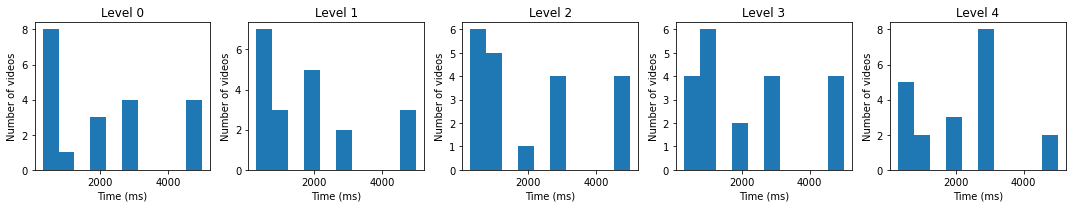

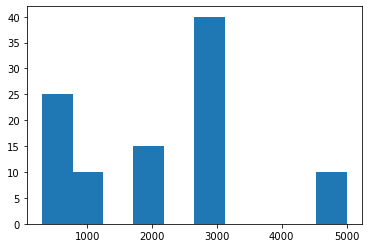

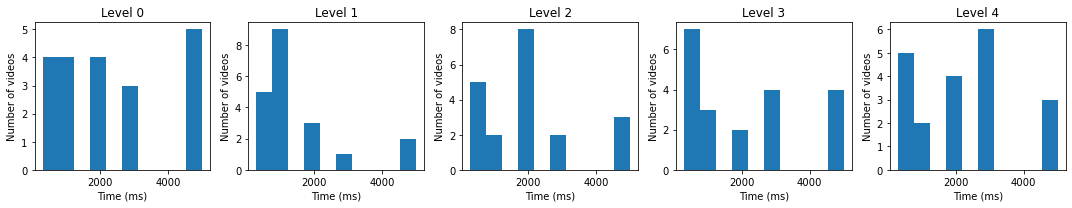

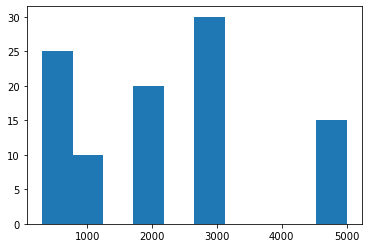

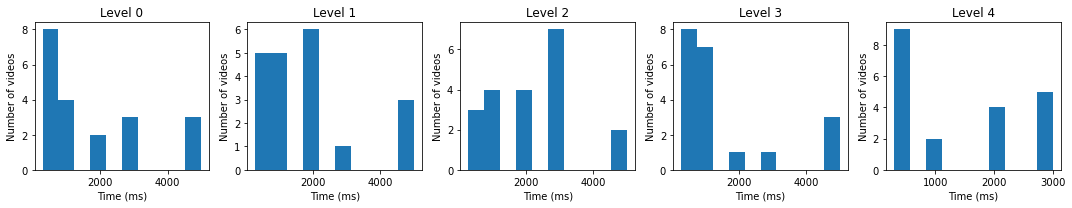

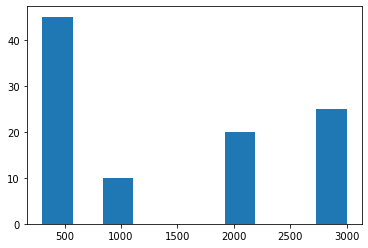

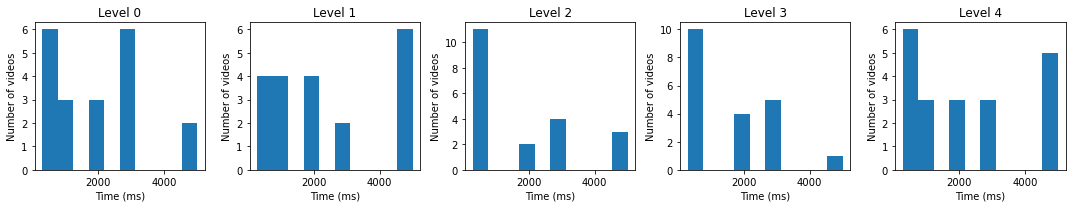

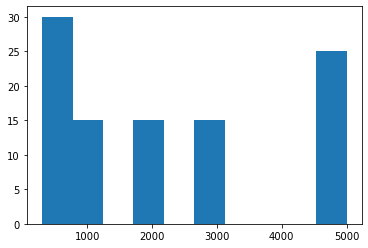

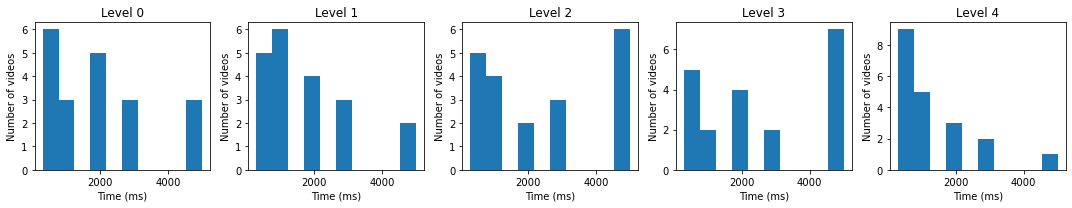

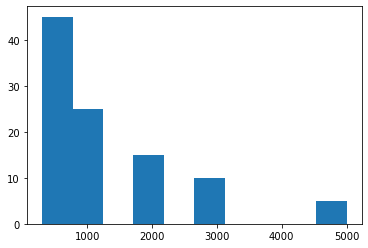

In [8]:
# Visualize the jsons

def vis_jsons(json):
    '''Plot histograms showing properties of given json: 
        1. Times in a level
        2. Proportion of reals and fakes
    '''

    number_of_levels = len(json)

    plt.figure(figsize=(15,3))
    for l in range(number_of_levels):
        plt.subplot(1, number_of_levels, l+1)
        plt.hist(np.array([x['time'] for x in json["level%d"%l]]))
        plt.title("Level %d"%l)
        plt.xlabel("Time (ms)")
        plt.ylabel("Number of videos")
        plt.tight_layout()
    plt.show()

    # Show barchart of times over the entire json
    plt.figure()   
    plt.hist(np.array([x['time'] for x in json["level%d"%l] for l in range(number_of_levels)]), bins = 10)
    plt.show()



vis_jsons(timedexp_jsons[0])
vis_jsons(timedexp_jsons[1])
vis_jsons(timedexp_jsons[2])
vis_jsons(timedexp_jsons[3])
vis_jsons(timedexp_jsons[4])

398


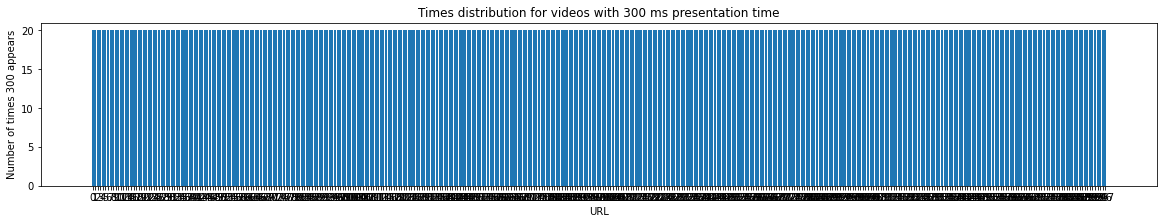

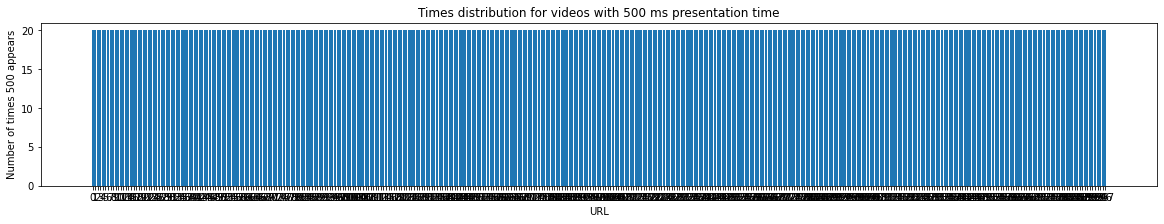

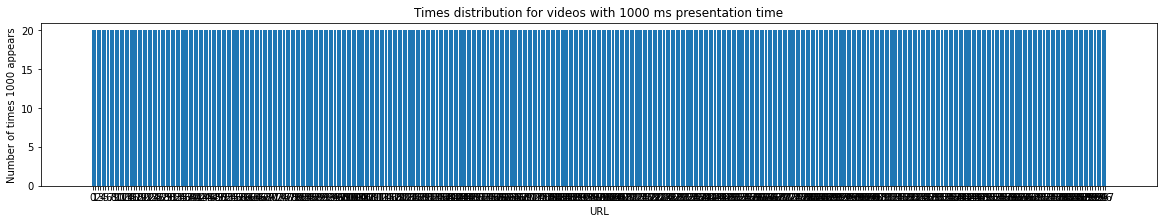

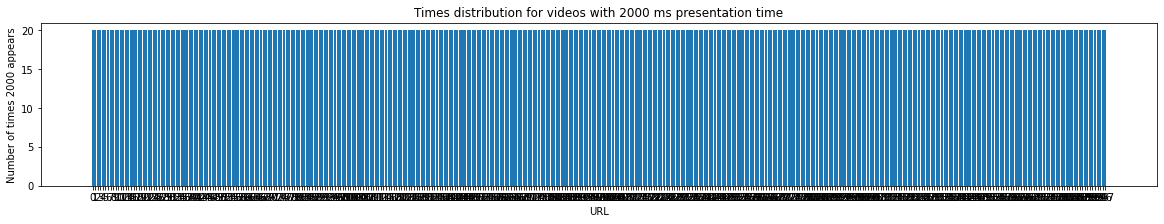

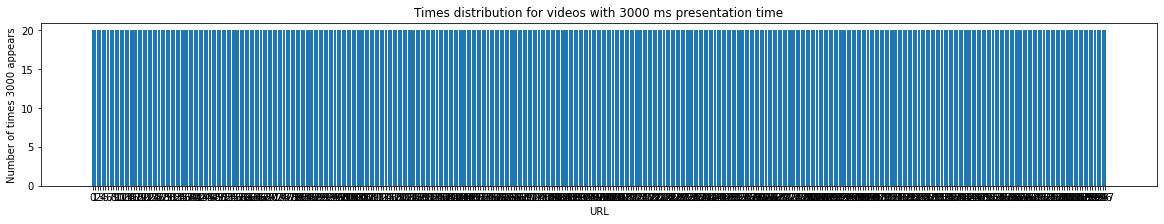

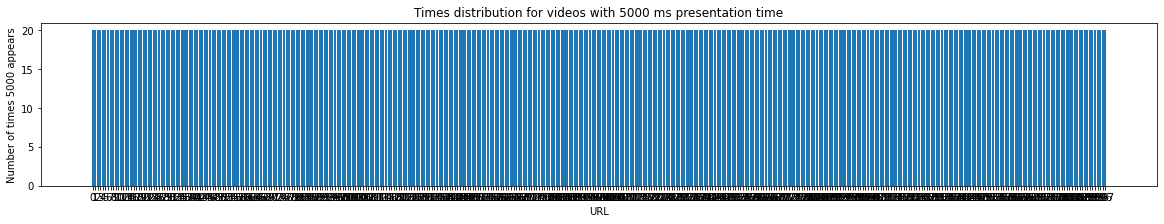

In [9]:
def view_distributions_of_video_times(json_folder, pres_times, fake_urls, cari_urls):
    """
    Checks all jsons in input folder and plots histogram of their distribution per times
    """
    
    # Get all jsons
    jsons = [json.load(open(path)) for path in glob.glob(json_folder+"/json_*.json")]

    video_times = {}

    # Initialize video_times dict
    for times in pres_times:
        video_times[times] = {}
        for url in fake_urls:
            video_times[times][url] = 0
        for url in cari_urls:
            video_times[times][url] = 0

    # Count videos per times
    for j in jsons:
        for lvl, lst in j.items():
            for e in lst:
                if e["label"] == "REAL": continue
                video_times[e["time"]][e["url"]] += 1


    print(len(video_times[500]))
    # Plot one bar chart per time
    for time in pres_times:
        plt.figure(figsize=[20,3])
        plt.bar(range(len(video_times[time])), list(video_times[time].values()))
        plt.xticks(range(len(video_times[time])))  #, list(video_times[time].keys()))
        plt.title("Times distribution for videos with %d ms presentation time" % time)
        plt.xlabel("URL")
        plt.ylabel("Number of times %d appears" % time)
        plt.show()

    

view_distributions_of_video_times("jsons", pres_times, fake_urls, cari_urls)